#  Setup the CNN 

In [1]:
from keras.layers import Flatten, Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.models import Model
from keras import backend as K

# we are using square images 128x128
imageSize = 128
# 5 x 5 dot array
dotsPerSide = 5
#our loss function will be the 25bit pattern used to create the image
encoding_dim = dotsPerSide * dotsPerSide

# this is our input placeholder
input_img = Input(shape=(imageSize, imageSize, 1))

#a convolution layer with padding and pooling functions
def ConvBlock(input, layers, filters):
    for i in range(layers):
        x = ZeroPadding2D()(input)
        x = Conv2D(filters, (3, 3), activation='relu')(x)
    
    return AveragePooling2D((2, 2), strides=(2, 2))(x)

#a fully connected block and our normalization function
def FCBlock(input):
    x = Dense(4096, activation='relu')(input)
    x = BatchNormalization()(x)
    return Dropout(0.5)(x)

#use a stack of convolutional layers, like VGG16
x = ConvBlock(input_img, 2, 64)
#x = ConvBlock(x, 2, 64)
x = ConvBlock(x, 2, 128)
x = ConvBlock(x, 3, 256)
x = ConvBlock(x, 3, 512)
#flatten out the convolutional layers, then regularize with batch normalization
x = Flatten()(x)

x = FCBlock(x)
#x = FCBlock(x)

# "loss" is the bit array for each image
loss = Dense(encoding_dim, activation='sigmoid')(x)

model = Model(input_img, loss)
model.compile(optimizer='adadelta', loss='binary_crossentropy')

#model.load_weights("./averagePoolWeights.h5", by_name=False)

Using TensorFlow backend.


# Import the Data

In [2]:
import numpy as np
from PIL import Image

#extract the bit pattern from the filename
def decodeFileName(hexString):
    number = np.zeros(25, dtype=np.bool)
    bit = 0
    for i in reversed(range(8)):
        nibble = int(hexString[i], 16)
        for j in range(4):
            if (bit < 25):
                number[bit] = (nibble & 0x1)        
                nibble = nibble >> 1
                bit = bit + 1
                
    return number

#take an image and return an NP float arrray
def img_to_float_array(img):
    img_array = np.asarray(img, dtype='float32')
    img_array = img_array.astype('float32') / 255.
    img_array = img_array.reshape((img_array.shape[0], img_array.shape[1], 1))
    return img_array

#use some BASH commands to load files randomly
def random_files(numMatches, directory):
    files = !ls {directory} |sort -R |tail -{numMatches}
    reutrnFiles = []
    for i in range(numMatches):
        reutrnFiles.append(files[i])
    return files
    
#load the images and lables
def loadImageBatch(batchSize=32, test=False):
    images = np.zeros((batchSize, imageSize, imageSize, 1))
    labels = np.zeros((batchSize, 25))
    
    directory = "./images2/train/"
    
    if (test):
        directory = "./images2/test/"
        
    imageFiles = random_files(batchSize, directory)
        
    for i in range(batchSize):
        fileName = imageFiles[i]
        labels[i] = decodeFileName(fileName[0:8])
        fileName = directory+imageFiles[i]
        images[i] = img_to_float_array(Image.open(fileName))
    
    return (images, labels)


# Train the model

In [ ]:
import numpy as np
from keras.callbacks import TensorBoard
import glob, os

batch_size = 32

#tensorboard callback
tensorboard = TensorBoard(log_dir='/tmp/LEDS',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=False)

for i in range(0, 30000):
    training_batch = loadImageBatch(batch_size)
    validation_batch = loadImageBatch(batch_size, test=True)
    model.fit(training_batch[0],
              training_batch[1],
              epochs=1,
              batch_size=batch_size,
              validation_data=validation_batch,
              callbacks=[tensorboard])
    print("run {}".format(i))

model.save_weights("./averagePoolWeights.h5")

# Calculate the percent of failures

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
from scipy import stats

#check to see how many images have misses one or more dots
n = 8000
threshold = 0.5

testSet = loadImageBatch(n, test=True)
predicted_labels = model.predict(testSet[0])
predicted_labels = stats.threshold(predicted_labels, threshmin=0, threshmax=threshold, newval=1.0)
predicted_labels = stats.threshold(predicted_labels, threshmin=threshold, threshmax=1.0, newval=0)

misses = 0
for i in range(n):
    score = np.absolute(testSet[1][i] - predicted_labels[i])
    if np.sum(score) > 0:
        misses = misses + 1
        
print(100*((n-misses)/n))   

92.8875


/home/brian/anaconda3/envs/keras-test/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `threshold` is deprecated!
stats.threshold is deprecated in scipy 0.17.0
  if sys.path[0] == '':
/home/brian/anaconda3/envs/keras-test/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `threshold` is deprecated!
stats.threshold is deprecated in scipy 0.17.0
  del sys.path[0]


# Investigate the failures

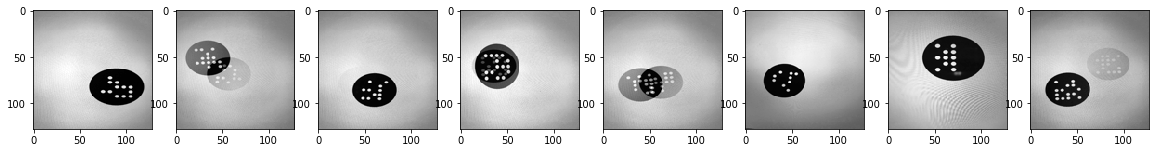

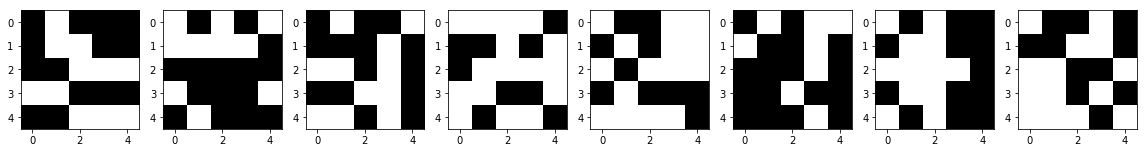

92.0


In [4]:
#Print out the images that didn't get all the dots.

import numpy as np
import matplotlib.pyplot as plt
import glob, os

def success(test, predicted):
    score = np.absolute(test - predicted)
    if np.sum(score) == 0:
        return True
    else:
        return False

n = 100
imageSize = 128
dotsPerSide = 5

testSet = loadImageBatch(n, test=True)
predicted_labels = model.predict(testSet[0])
predicted_labels = predicted_labels.round(0)

failures = []

for i in range(n):
    test = testSet[1][i]
    predicted = predicted_labels[i]
    if (success(test, predicted) == False):
        failures.append((testSet[0][i],predicted))

misses = len(failures)

plt.figure(figsize=(20, 8))
for i in range(misses):
    ax = plt.subplot(2, misses, i + 1)
    plt.imshow(failures[i][0].reshape(imageSize, imageSize))
    plt.gray()
plt.show()

plt.figure(figsize=(20, 8))
for i in range(misses):
    ax = plt.subplot(2, misses, i + 1)
    bitArray = failures[i][1].reshape(dotsPerSide, dotsPerSide)
    plt.imshow(np.rot90(bitArray))
    plt.gray()
plt.show()


print(100-(100*misses/n))  